<a href="https://colab.research.google.com/github/ngjimenez/1-Audio-Classification/blob/main/Audio_Classification_Frozen_vs_Mamma_Mia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Author

* Student Name: Natalie Jimenez
* Student ID: 210347863

# 2. Problem Formulation

As part of this project, I want to classify an input audio samples as either of the following:
* A hum sample of Frozen
* A whistle sample of Frozen
* A hum sample of Mamma Mia
* A whistle sample of Mamma Mia

This is an interesting problem to me because I will attempt this classification by chaining together machine learning models.

# 3. Machine Learning Pipeline


![picture](https://drive.google.com/uc?export=view&id=152t0LEMagbrqUQ6602qQBm8Ry-JSeKX9)


# 4. Transformation Stage

## Section 4.1 - Feature Extaction

**Input**: audio waveforms

I looked at 10 different features, and a summary of this can be found in Section 10.1 - Feature Selection. I looked at the mean of the following features:
* Power
* Pitch
* Pitch Standard Deviation
* Voiced FR
* Spectral Rolloff
* Spectral Bandwidth
* Spectral Centroid
* MFCCs
* Tempo
* Root Mean Square Energy
<br>
<br>

I found these features through a variety of sources:
* Starter Kit
* A Study called "A New Front-End for Classification of Non-Speech Sounds: A Study on Human Whistle", which described the use of Spectral Rolloff, Spectral Bandwidth, Spectral Centroid, MFCCs in classifying whistle and speech audio samples.
<br>
(Nandwana, Mahesh & Boril, Hynek & Hansen, John. (2015). A New Front-End for Classification of Non-Speech Sounds: A Study on Human Whistle. 10.21437/Interspeech.2015-436.)
<br>
<br>

I then plotted the distribution of each values on a line plot with the Hums/Whistle labels and Song Name lables. 

* For Hums/Whistles: I did observe good separation between hums and whistles when looking at Pitch and Voiced FR. So, I chose these two predictors.

* For song name labels, I did not observe any good separation between the Frozen and Mamma Mia samples. However, I did note:
  * Spectral Rolloff mean, Spectral Centroid mean, and Spectral Bandwidth mean were highly linearly correlated. So, I decided to exclude Spectral centroid and Spectral Bandwidth because having linearly predictors could bias the analysis.

  * Spectral Rolloff mean and Tempo mean were not linearly correlated, so I chose these as the features for this project.


**Output**: means of Pitch Mean, Voiced_FR, Spectral Rolloff mean, Tempo mean

# 5. Modelling

I attempted the following combinations with SVM:
* Predicting if a sample was a hum or whistle with:
  * Two pitch predictors
  * One spectral and one tempo predictor
  * All four predictors

* Predicting if a sample belonged to Frozen or Mamma Mia with:
  * All four predictors
    * Employing GridSearchCV to fine tune the parameters

* Multilabel Model with Scikit-Multilearn
  * Per the package’s documentation, “scikit-multilearn is a Python module capable of performing multi-label learning tasks. It is built on-top of various scientific Python packages (numpy, scipy) and follows a similar API to that of scikit-learn.”

   * The Classifier Chain function in this packages allows the output of one classifier to be included as the input of the next classifier.
   * Again, per the documentation, “The first classifier is trained just on the input space, and then each next classifier is trained on the input space and all previous classifiers in the chain.”

  * All 4 predictors
  * All 4 predictors with the best parameters from the previous section


# 6. Methodology

I will be using and comparing training and validation accuracies to compare the different models and methods. Additionally, I will use GridSearchCV to test different parameters for SVM.

# 7. Dataset

## Section 7.1 - Describe Dataset

*Describe the dataset that you will use to create your models and validate them. If you need to preprocess it, do it here. Include visualisations too. You can visualise raw data samples or extracted features.*


This dataset is imbalanced because there are more hum samples than whistle samples. The lowest number of whistles samples in the Frozen and Mamma Mia datasets is 114, so I will use 114 hums from the Frozen set and 114 hums from the Mamma Mia set.

## Section 7.2 - Load Data

In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm

!pip install scikit-multilearn

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_frozen = '/content/drive/MyDrive/Data/MLEndHW/Repository_Frozen/*.wav'
files_frozen = glob.glob(path_frozen)
len(files_frozen)

410

In [ ]:
path_mamma = '/content/drive/MyDrive/Data/MLEndHW/Repository_Mamma/*.wav'
files_mamma = glob.glob(path_mamma)
len(files_mamma)

412

## Section 7.3 - Dealing with Inconsistent Naming

The files are inconsistently named. To deal with this, I have searched through the file names of each folder (Frozen and Mamma Mia samples were saved in separate folders) for the following strings:

In [ ]:
hum_lowercase = 'hu'
whistle_lowercase = 'whi'

hum_uppercase = 'Hu'
whistle_uppercase = 'Whi'

While spelling errors do occur, I assumed they would be less likely at the beginning of the word.

In [ ]:
frozen_hums = []
frozen_whistles = []
for file in files_frozen:
  if hum_lowercase in file:
    frozen_hums.append(file)
  
  if hum_uppercase in file:
    frozen_hums.append(file)
  
  if whistle_lowercase in file:
    frozen_whistles.append(file)
  
  if whistle_uppercase in file:
    frozen_whistles.append(file)

print(len(frozen_hums))
print(len(frozen_whistles))

293
116


There are 409 combined Frozen hums and whistles.

In [ ]:
mamma_hums = []
mamma_whistles = []
for file in files_mamma:
  if hum_lowercase in file:
    mamma_hums.append(file)
  
  if hum_uppercase in file:
    mamma_hums.append(file)
  
  if whistle_lowercase in file:
    mamma_whistles.append(file)
  
  if whistle_uppercase in file:
    mamma_whistles.append(file)

print(len(mamma_hums))
print(len(mamma_whistles))

291
121


There are 402 total Mamma Mia hums and whistles. 


Overall, not too many samples were lost


As mentioned above, I will take 114 samples of the following to solve the imabalanced samples problem:
* Frozen hums
* Frozen whistles
* Mamma Mia hums
* Mamma Mia whistles

## Section 7.4 - Feature Extraction (Pitch)

This section shows the code used to extract the chosen features. All features were saved in a CSV file because it was taking 30 minutes each time I ran the feature extraction code.

In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [ ]:
def get_features1(files, scale_audio=False, onlySingleDigit=False):
  X =[]
  for file in files:
    fs = None # if None, fs would be 22050
    x, sampling_rate = librosa.load(file,sr=fs)
    if scale_audio: 
      x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,sampling_rate,winLen=0.02)
      
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)

    # Spectral Rolloff
    sr = librosa.feature.spectral_rolloff(x, sr=sampling_rate)
    sr_mean = sr.mean()

    # Spectral Bandwidth
    sb = librosa.feature.spectral_bandwidth(x, sr=sampling_rate)
    sb_mean = sb.mean()

    # Spectral Centroid
    sc = librosa.feature.spectral_centroid(x, sr=sampling_rate)
    sc_mean = sc.mean()

    # MFCCs
    mfcc = librosa.feature.mfcc(x, sr=sampling_rate)
    mfcc_mean = mfcc.mean()

    # Tempo
    tempo = librosa.feature.tempogram(x, sr=sampling_rate)
    tempo_mean = tempo.mean()

    # RMSE
    rms = librosa.feature.rms(x)
    rms_mean = rms.mean()


    xi = [power,pitch_mean,pitch_std,voiced_fr, sr_mean, sb_mean, sc_mean, mfcc_mean, tempo_mean, rms_mean]
    X.append(xi)


  return np.array(X)



```
X_frozen_hums = get_features1(frozen_hums[0:114], scale_audio=True, onlySingleDigit=True)
print(X_frozen_hums.shape)

X_mamma_hums = get_features1(mamma_hums[0:114], scale_audio=True, onlySingleDigit=True)
print(X_mamma_hums.shape)

X_frozen_whistles = get_features1(frozen_whistles, scale_audio=True, onlySingleDigit=True)
print(X_frozen_whistles.shape)

X_mamma_whistles = get_features1(mamma_whistles, scale_audio=True, onlySingleDigit=True)
print(X_mamma_whistles.shape)
```
* (114, 10)
* (114, 10)
* (116, 10)
* (121, 10)




```
# Save 10 features samples to CSV
pd.DataFrame(X_frozen_hums).to_csv("/content/drive/MyDrive/Data/MLEndHW/frozen_hums.csv", header=None)
pd.DataFrame(X_frozen_whistles).to_csv("/content/drive/MyDrive/Data/MLEndHW/frozen_whistles.csv", header=None)
pd.DataFrame(X_mamma_hums).to_csv("/content/drive/MyDrive/Data/MLEndHW/mamma_hums.csv", header=None)
pd.DataFrame(X_mamma_whistles).to_csv("/content/drive/MyDrive/Data/MLEndHW/mamma_whistles.csv", header=None)
```



In [ ]:
# Make df of Frozen hums
fhums = pd.read_csv("/content/drive/MyDrive/Data/MLEndHW/frozen_hums.csv", names=['power','pitch_mean','pitch_std','voiced_fr', 'sr_mean', 'sb_mean', 'sc_mean','mfcc_mean', 'tempo_mean', 'rms_mean'])
fhums['H or W'] = 1
fhums['Class'] = 1
print(f'Shape of Frozen hums df: {fhums.shape}')

# Make df of Frozen whistles
fwhistles = pd.read_csv("/content/drive/MyDrive/Data/MLEndHW/frozen_whistles.csv", names=['power','pitch_mean','pitch_std','voiced_fr', 'sr_mean', 'sb_mean', 'sc_mean','mfcc_mean', 'tempo_mean', 'rms_mean'])
fwhistles['H or W'] = 0
fwhistles['Class'] = 1
print(f'\nShape of Frozen whistles df: {fwhistles.shape}')

# Make df of Mamma Mia hums
mhums = pd.read_csv("/content/drive/MyDrive/Data/MLEndHW/mamma_hums.csv", names=['power','pitch_mean','pitch_std','voiced_fr', 'sr_mean', 'sb_mean', 'sc_mean','mfcc_mean', 'tempo_mean', 'rms_mean'])
mhums['H or W'] = 1
mhums['Class'] = 0
print(f'\nShape of Mamma Mia hums df: {mhums.shape}')

# Make df of Mamma Mia whistles
mwhistles = pd.read_csv("/content/drive/MyDrive/Data/MLEndHW/mamma_whistles.csv", names=['power','pitch_mean','pitch_std','voiced_fr', 'sr_mean', 'sb_mean', 'sc_mean','mfcc_mean', 'tempo_mean', 'rms_mean'])
mwhistles['H or W'] = 0
mwhistles['Class'] = 0
print(f'\nShape of Mamma Mia whistles df: {mwhistles.shape}')

Shape of Frozen hums df: (114, 12)

Shape of Frozen whistles df: (116, 12)

Shape of Mamma Mia hums df: (114, 12)

Shape of Mamma Mia whistles df: (121, 12)


In [ ]:
all_features = fhums

all_features = all_features.append(fwhistles)
all_features = all_features.append(mhums)
all_features = all_features.append(mwhistles)
all_features['Plot Y'] = 0
print(f'The shape of all features is: {all_features.shape}\n')
display(all_features.head())

The shape of all features is: (465, 13)



,power,pitch_mean,pitch_std,voiced_fr,sr_mean,sb_mean,sc_mean,mfcc_mean,tempo_mean,rms_mean,H or W,Class,Plot Y
0,0.021225,109.013378,16.305638,0.819720,2963.818036,3865.174093,1729.674753,-1.976928,0.177205,0.122063,1,1,0
1,0.007168,156.445996,25.178615,0.695165,3180.002915,3167.286827,1850.120333,-9.696729,0.116735,0.063780,1,1,0
2,0.068075,210.743320,33.990213,0.833448,5255.488897,4338.772037,2782.624867,-7.242121,0.213219,0.229778,1,1,0
3,0.069781,208.004928,39.000433,0.695428,2301.893062,2162.669623,1305.789071,-14.218401,0.189260,0.186323,1,1,0
4,0.036784,371.577494,55.766593,0.811306,4068.706133,2573.343453,2263.677712,-22.186611,0.139304,0.156963,1,1,0


In [ ]:
# Drop columns with features we don't need
all_features.drop(columns=['power',	'pitch_std', 'sb_mean',	'sc_mean', 'mfcc_mean',	'rms_mean'], inplace=True)
all_features

,pitch_mean,voiced_fr,sr_mean,tempo_mean,H or W,Class,Plot Y
0,109.013378,0.819720,2963.818036,0.177205,1,1,0
1,156.445996,0.695165,3180.002915,0.116735,1,1,0
2,210.743320,0.833448,5255.488897,0.213219,1,1,0
3,208.004928,0.695428,2301.893062,0.189260,1,1,0
4,371.577494,0.811306,4068.706133,0.139304,1,1,0
...,...,...,...,...,...,...,...
116,398.200843,0.459494,4785.981170,0.124108,0,0,0
117,409.047345,0.505891,10929.092934,0.152101,0,0,0
118,399.267857,0.614554,7082.097899,0.189953,0,0,0
119,420.450056,0.692776,6648.193742,0.128821,0,0,0


## Section 7.5 - Feature Visualization

### Section 7.5.1 - Comparing Features with Respect to Whistle/Hum Label

I inspected the individual features in Section 10.1. Here I mainly double checked that the chosen features did not have strong linear correlation.

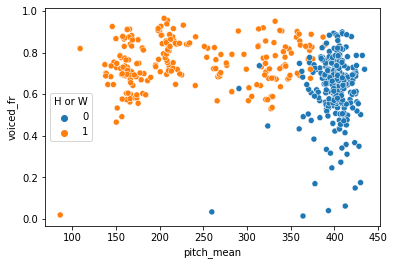

In [ ]:
sns.scatterplot(x='pitch_mean', y="voiced_fr", data=all_features, hue="H or W")

Pitch Mean and Voice FR provide good separation for hums/whistles

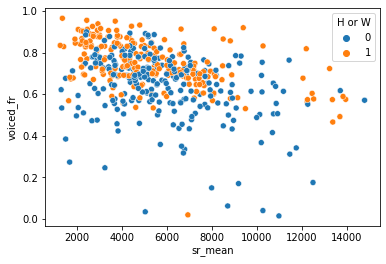

In [ ]:
sns.scatterplot(x='sr_mean', y="voiced_fr", data=all_features, hue="H or W")

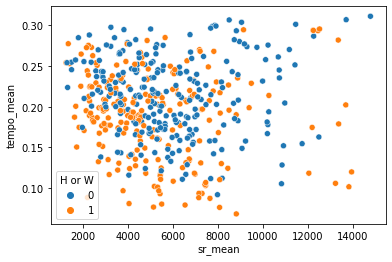

In [ ]:
sns.scatterplot(x='sr_mean', y="tempo_mean", data=all_features, hue="H or W")

### Section 7.5.2 - Feature Relationships with Respect to Class (Song Type)

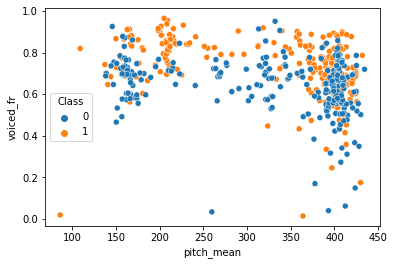

In [ ]:
sns.scatterplot(x='pitch_mean', y="voiced_fr", data=all_features, hue="Class")

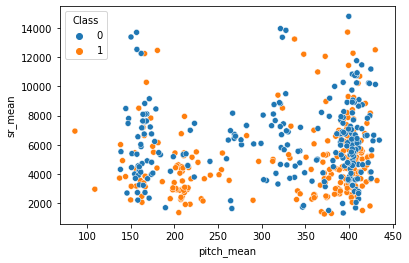

In [ ]:
sns.scatterplot(x='pitch_mean', y="sr_mean", data=all_features, hue="Class")

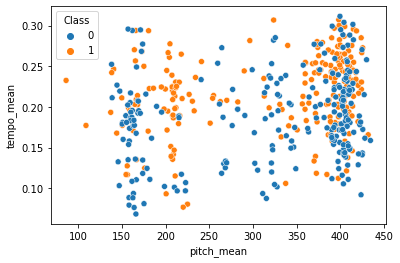

In [ ]:
sns.scatterplot(x='pitch_mean', y="tempo_mean", data=all_features, hue="Class")

While none of the features provide good separation for song type at first glance, the features above are not linearly correlated so they were chosen as the predictors.

# Section 8 - Results

In [ ]:
# Separate into X and y
X = all_features.iloc[:, :4].values
y2 = all_features.iloc[:, 4:6].values

print(f'This is the shape of X: {X.shape}')
print(f'This is the shape of y: {y2.shape}')

This is the shape of X: (465, 4)
This is the shape of y: (465, 2)


In [ ]:
# Split into train/val

X_train, X_val, y2_train, y2_val = train_test_split(X,y2,test_size=0.3)
print(X_train.shape, X_val.shape, y2_train.shape, y2_val.shape)

(325, 4) (140, 4) (325, 2) (140, 2)


In [ ]:
from sklearn.preprocessing import StandardScaler
# Standardize values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

## Section 8.1 - One Label Type (Hum or Whistle) SVM

### Section 8.1.1 - Four Predictors

In [ ]:
y_hw_train = y2_train[:, 0]
y_hw_train.shape

(325,)

In [ ]:
y_hw_val = y2_val[:, 0]
y_hw_val.shape

(140,)

In [ ]:
model  = svm.SVC(C=1)
model.fit(X_train,y_hw_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_hw_train))
print('Validation  Accuracy', np.mean(yv_p==y_hw_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.9815384615384616
Validation  Accuracy 0.9714285714285714
The support vectors are (88, 4)


Based on the training and validation accuracies, it seems like all four predictors do well at differentiating between a hum or whistle.

### Section 8.1.2 - Two Predictors (Pitch Mean and Voiced_FR)

In [ ]:
model  = svm.SVC(C=1)
model.fit(X_train[:, 0:2],y_hw_train)

yt_p = model.predict(X_train[:, 0:2])
yv_p = model.predict(X_val[:, 0:2])

print('Training Accuracy', np.mean(yt_p==y_hw_train))
print('Validation  Accuracy', np.mean(yv_p==y_hw_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.9815384615384616
Validation  Accuracy 0.9714285714285714
The support vectors are (58, 2)


Training and validation accuracy for all four features and pitch features are about the same. So, both seem to predict if a sample is a hum or whistle with high accuracy.

### Section 8.1.3 - Two Predictors (Spectral and Tempo Features)

In [ ]:
model  = svm.SVC(C=1)
model.fit(X_train[:, 2:4],y_hw_train)

yt_p = model.predict(X_train[:, 2:4])
yv_p = model.predict(X_val[:, 0:2])

print('Training Accuracy', np.mean(yt_p==y_hw_train))
print('Validation  Accuracy', np.mean(yv_p==y_hw_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.68
Validation  Accuracy 0.65
The support vectors are (252, 2)


When only using the spectral and tempo features, both training and validation accuracy fall to the mid-60% range. So, it seems pitch features are better at differentiating between hums and whistles. 

## Section 8.2 - One Label (Song Type - Frozen or Mamma Mia)

### Section 8.2.1 - Four Predictors

In [ ]:
y_fm_train = y2_train[:, 1]
y_fm_train.shape

(325,)

In [ ]:
y_fm_val = y2_val[:, 1]
y_fm_val.shape

(140,)

In [ ]:
model  = svm.SVC(C=1)
model.fit(X_train,y_fm_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_fm_train))
print('Validation  Accuracy', np.mean(yv_p==y_fm_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.7630769230769231
Validation  Accuracy 0.7357142857142858
The support vectors are (215, 4)


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [10, 1, 0.1, 0.01, 0.001],}

svm_model = svm.SVC()

svm_gridsearch = GridSearchCV(svm_model, param_grid, cv=5)
svm_gridsearch.fit(X_train, y_fm_train)

print('Best hyperparameter setting: {0}.'.format(svm_gridsearch.best_estimator_))
print('Average accuracy across folds of best hyperparameter setting: {0}.'.format(svm_gridsearch.best_score_))
print('Training dataset accuracy of best hyperparameter setting: {0}.'.format(svm_gridsearch.score(X_train, y_fm_train)))
print('Validation dataset accuracy of best hyperparameter setting: {0}.'.format(svm_gridsearch.score(X_val, y_fm_val)))

Best hyperparameter setting: SVC(C=100, gamma=0.001).
Average accuracy across folds of best hyperparameter setting: 0.716923076923077.
Training dataset accuracy of best hyperparameter setting: 0.7292307692307692.
Validation dataset accuracy of best hyperparameter setting: 0.7285714285714285.


When classifying a sample as belonging to Frozen or Mamma Mia, the training  accuracy of the best estimator is about 76% and the validation accuracy of the best estimator is about 74%. Since the two accuracies are close to one another, we can say the model is neither overfitting nor underfitting. While the validation accuracy is not the best, it is better than a random coin toss. The model is able to generalize unseen examples.

## Section 8.3 - Multi-label Models

In [ ]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.metrics import accuracy_score, confusion_matrix

### Section 8.3.1 - Four Predictors

In [ ]:
def build_model(model,mlb_estimator,xtrain,ytrain,xval,yval):
    clf = mlb_estimator(model)
    clf.fit(xtrain,ytrain)
    yt_pred = clf.predict(xtrain)
    yv_pred = clf.predict(xval)
    train_acc = accuracy_score(ytrain,yt_pred)
    val_acc = accuracy_score(yval,yv_pred)
    result = {"Training accuracy:":train_acc,"Validation accuracy":val_acc}
    return result

In [ ]:
svm_model  = svm.SVC()

clf_chain_model = build_model(svm_model,ClassifierChain,X_train,y2_train,X_val,y2_val)
clf_chain_model

{'Training accuracy:': 0.76, 'Validation accuracy': 0.6928571428571428}

In [ ]:
svm_model  = svm.SVC(C=1000, gamma=0.001)

clf_chain_model = build_model(svm_model,ClassifierChain,X_train,y2_train,X_val,y2_val)
clf_chain_model

{'Training accuracy:': 0.7292307692307692,
 'Validation accuracy': 0.7071428571428572}

When using the default SVM parameters, the training accuracy of the SVM chain classifier is 76% and the validation accuracy is about 69%. However, when we use the hyperparameters found through GridSearch in the previous section for song type, validation accuracy moves up to about 71%.

# Section 9 - Conclusions

**Conclusions**

Overall, the chain classifier worked better than I had expected and the validation accuracy increased by using the tuned parameters from classifying song types. I chose to tune these parameters specifically because the accuracy for song recognition was lower. 
<br><br>
**Improvements**

I was not experienced in chaining classifiers or multi-label classifying prior to this project, so I spent some time looking into it. There are multiple ways to deal with multi-label classification, and chaining models is one way of many to do it. It seemed the most intuitive method to me, so that's why I chose to do it. In an ideal scenario, I would employ two different types of models and chain them together to find the final output and I would use ChainClassifer() along with GridSearchCV to find the best parameters for each of the different models. 



# Section 10 - Appendix

## Section 10.1 - Feature Selection

In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [ ]:
def get_features1(files, scale_audio=False, onlySingleDigit=False):
  X =[]
  for file in files:
    fs = None # if None, fs would be 22050
    x, sampling_rate = librosa.load(file,sr=fs)
    if scale_audio: 
      x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,sampling_rate,winLen=0.02)
      
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)

    # Spectral Rolloff
    sr = librosa.feature.spectral_rolloff(x, sr=sampling_rate)
    sr_mean = sr.mean()

    # Spectral Bandwidth
    sb = librosa.feature.spectral_bandwidth(x, sr=sampling_rate)
    sb_mean = sb.mean()

    # Spectral Centroid
    sc = librosa.feature.spectral_centroid(x, sr=sampling_rate)
    sc_mean = sc.mean()

    # MFCCs
    mfcc = librosa.feature.mfcc(x, sr=sampling_rate)
    mfcc_mean = mfcc.mean()

    # Tempo
    tempo = librosa.feature.tempogram(x, sr=sampling_rate)
    tempo_mean = tempo.mean()

    # RMSE
    rms = librosa.feature.rms(x)
    rms_mean = rms.mean()


    xi = [power,pitch_mean,pitch_std,voiced_fr, sr_mean, sb_mean, sc_mean, mfcc_mean, tempo_mean, rms_mean]
    X.append(xi)


  return np.array(X)

In [ ]:
# Make df of Frozen hums
fhums = pd.read_csv("/content/drive/MyDrive/Data/MLEndHW/frozen_hums.csv", names=['power','pitch_mean','pitch_std','voiced_fr', 'sr_mean', 'sb_mean', 'sc_mean',' mfcc_mean', 'tempo_mean', 'rms_mean'])
fhums['H or W'] = 1
fhums['Class'] = 1
print(f'Shape of Frozen hums df: {fhums.shape}')

# Make df of Frozen whistles
fwhistles = pd.read_csv("/content/drive/MyDrive/Data/MLEndHW/frozen_whistles.csv", names=['power','pitch_mean','pitch_std','voiced_fr', 'sr_mean', 'sb_mean', 'sc_mean',' mfcc_mean', 'tempo_mean', 'rms_mean'])
fwhistles['H or W'] = 0
fwhistles['Class'] = 1
print(f'\nShape of Frozen whistles df: {fwhistles.shape}')

# Make df of Mamma Mia hums
mhums = pd.read_csv("/content/drive/MyDrive/Data/MLEndHW/mamma_hums.csv", names=['power','pitch_mean','pitch_std','voiced_fr', 'sr_mean', 'sb_mean', 'sc_mean',' mfcc_mean', 'tempo_mean', 'rms_mean'])
mhums['H or W'] = 1
mhums['Class'] = 0
print(f'\nShape of Mamma Mia hums df: {mhums.shape}')

# Make df of Mamma Mia whistles
mwhistles = pd.read_csv("/content/drive/MyDrive/Data/MLEndHW/mamma_whistles.csv", names=['power','pitch_mean','pitch_std','voiced_fr', 'sr_mean', 'sb_mean', 'sc_mean',' mfcc_mean', 'tempo_mean', 'rms_mean'])
mwhistles['H or W'] = 0
mwhistles['Class'] = 0
print(f'\nShape of Mamma Mia whistles df: {mwhistles.shape}')

Shape of Frozen hums df: (114, 12)

Shape of Frozen whistles df: (116, 12)

Shape of Mamma Mia hums df: (114, 12)

Shape of Mamma Mia whistles df: (121, 12)


In [ ]:
all_features = fhums

all_features = all_features.append(fwhistles)
all_features = all_features.append(mhums)
all_features = all_features.append(mwhistles)
all_features['Plot Y'] = 0
print(f'The shape of all features is: {all_features.shape}\n')
display(all_features.head())

The shape of all features is: (465, 13)



,power,pitch_mean,pitch_std,voiced_fr,sr_mean,sb_mean,sc_mean,mfcc_mean,tempo_mean,rms_mean,H or W,Class,Plot Y
0,0.021225,109.013378,16.305638,0.819720,2963.818036,3865.174093,1729.674753,-1.976928,0.177205,0.122063,1,1,0
1,0.007168,156.445996,25.178615,0.695165,3180.002915,3167.286827,1850.120333,-9.696729,0.116735,0.063780,1,1,0
2,0.068075,210.743320,33.990213,0.833448,5255.488897,4338.772037,2782.624867,-7.242121,0.213219,0.229778,1,1,0
3,0.069781,208.004928,39.000433,0.695428,2301.893062,2162.669623,1305.789071,-14.218401,0.189260,0.186323,1,1,0
4,0.036784,371.577494,55.766593,0.811306,4068.706133,2573.343453,2263.677712,-22.186611,0.139304,0.156963,1,1,0


### Individual Features - Whistles/Hums

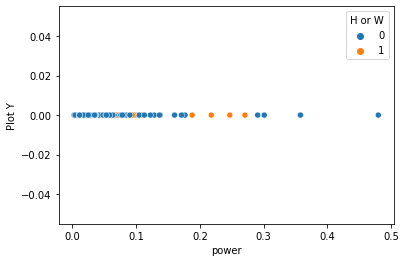

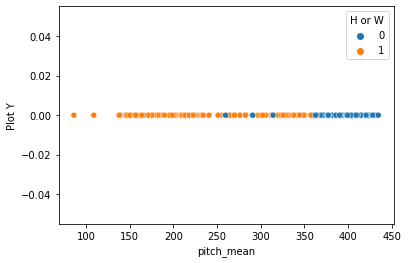

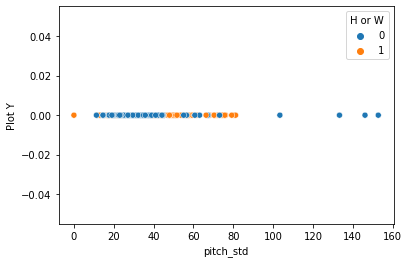

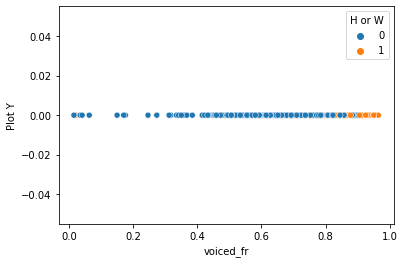

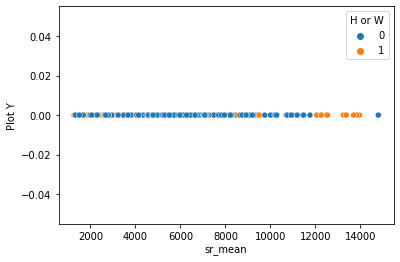

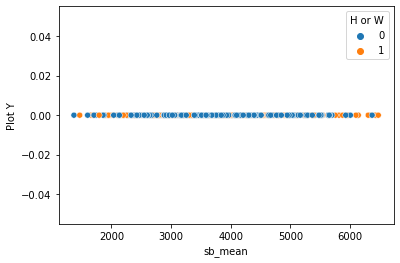

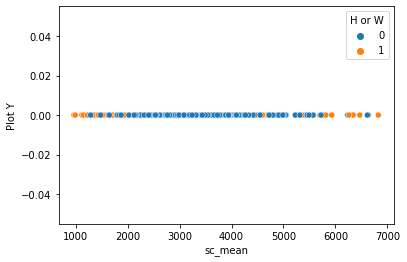

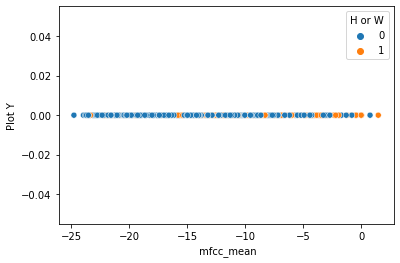

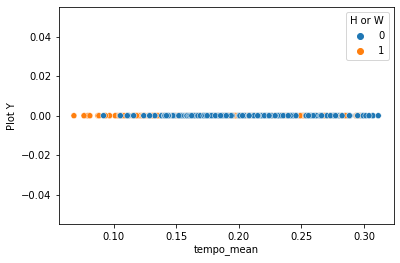

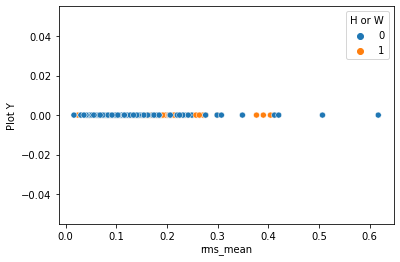

In [ ]:
import seaborn as sns
cols = all_features.columns[0:10]
for col in cols:
  sns.scatterplot(x=col, y="Plot Y", data=all_features, hue="H or W")
  plt.show()

### Individual Features - Song Types

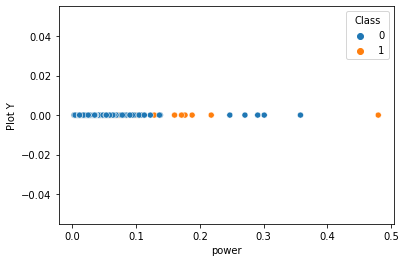

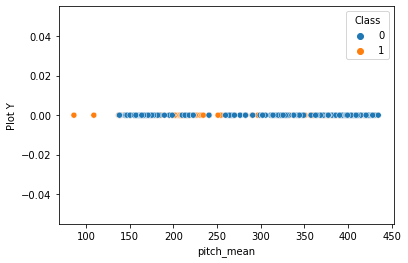

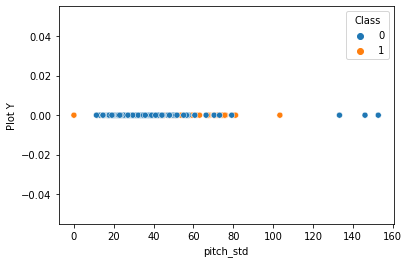

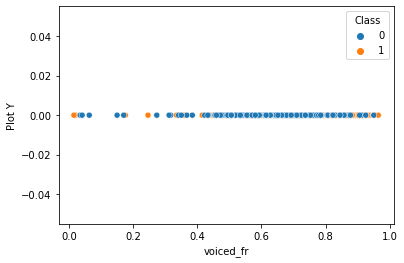

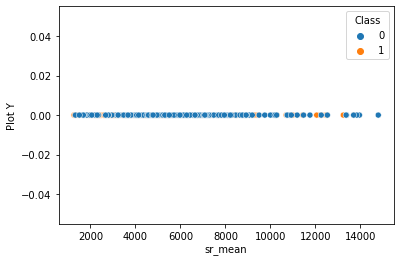

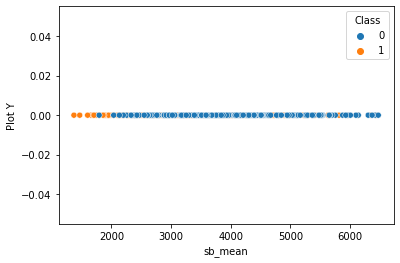

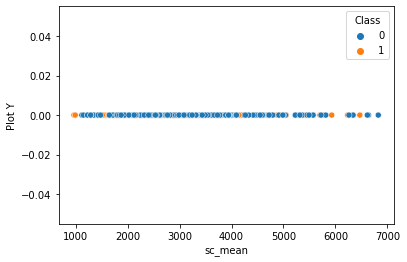

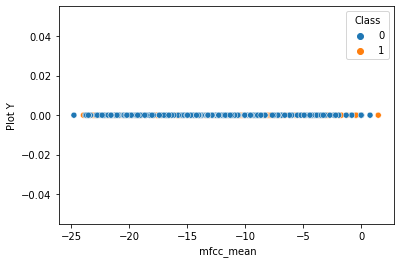

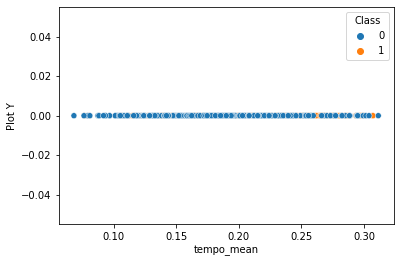

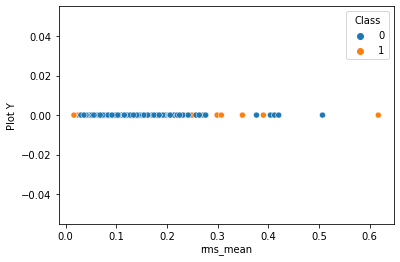

In [ ]:
import seaborn as sns
cols = all_features.columns[0:10]
for col in cols:
  sns.scatterplot(x=col, y="Plot Y", data=all_features, hue="Class")
  plt.show()

### Predictor Relationships with Respect to Hums

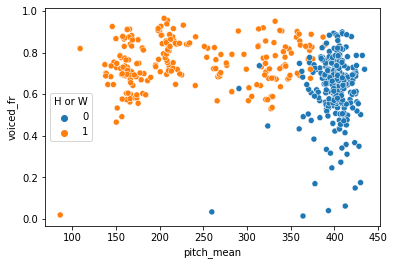

In [ ]:
sns.scatterplot(x='pitch_mean', y="voiced_fr", data=all_features, hue="H or W")

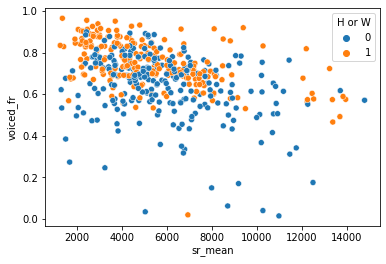

In [ ]:
sns.scatterplot(x='sr_mean', y="voiced_fr", data=all_features, hue="H or W")

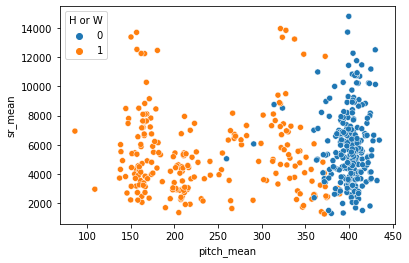

In [ ]:
sns.scatterplot(x='pitch_mean', y="sr_mean", data=all_features, hue="H or W")

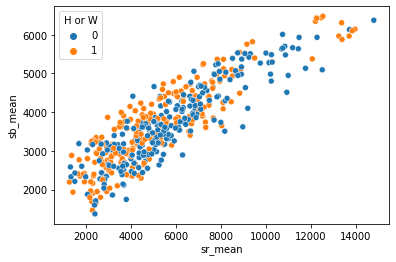

In [ ]:
sns.scatterplot(x='sr_mean', y="sb_mean", data=all_features, hue="H or W")

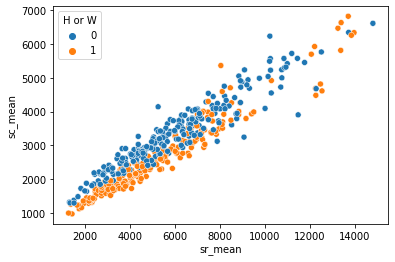

In [ ]:
sns.scatterplot(x='sr_mean', y="sc_mean", data=all_features, hue="H or W")

### Predictor Relationships with Respect to Song Class

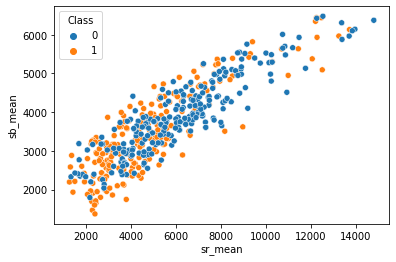

In [ ]:
sns.scatterplot(x='sr_mean', y="sb_mean", data=all_features, hue="Class")

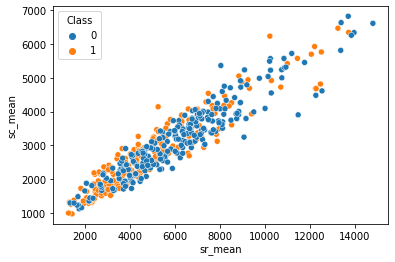

In [ ]:
sns.scatterplot(x='sr_mean', y="sc_mean", data=all_features, hue="Class")

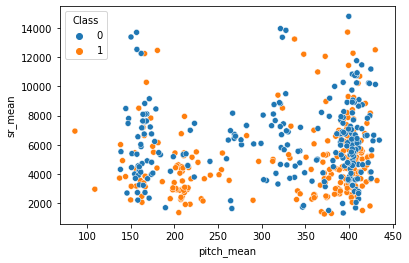

In [ ]:
sns.scatterplot(x='pitch_mean', y="sr_mean", data=all_features, hue="Class")

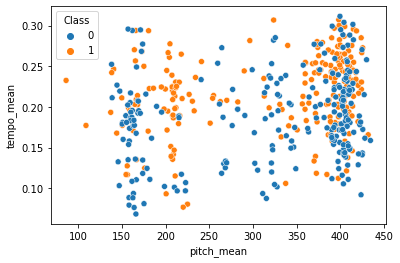

In [ ]:
sns.scatterplot(x='pitch_mean', y="tempo_mean", data=all_features, hue="Class")

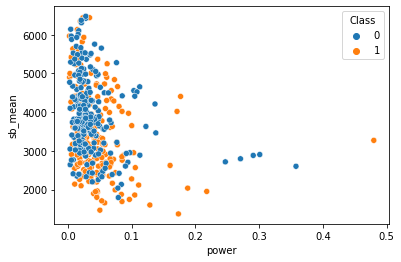

In [ ]:
sns.scatterplot(x='power', y="sb_mean", data=all_features, hue="Class")